In [1]:
# Moving window plot ngrams
from cdp_data import CDPInstances, datasets

# for infra_slug in [
#     CDPInstances.Seattle,
#     CDPInstances.KingCounty,
#     CDPInstances.
# ]

seattle_df = datasets.get_session_dataset(
    CDPInstances.Seattle,
    store_transcript=True,
    replace_py_objects=True,
    start_datetime="2022-09-01",
)
seattle_df.shape

Fetching each model attached to event_ref:   0%|          | 0/521 [00:00<?, ?it/s]

Fetching transcripts:   0%|          | 0/521 [00:00<?, ?it/s]

(521, 13)

In [2]:
# Setup parallel processing
from distributed import Client, LocalCluster

cluster = LocalCluster(processes=True)
client = Client(cluster)
client.dashboard_link

'http://127.0.0.1:8787/status'

In [3]:
from cdp_backend.pipeline.transcript_model import Transcript
from sklearn.feature_extraction.text import CountVectorizer
from dask import delayed
from nltk.stem.snowball import SnowballStemmer
import re
import pandas as pd

# Stem words before counting
stemmer = SnowballStemmer("english")

# Ignore numbers
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"\d+", "", text)
    return text

# Construct custom count vectorizer
class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])

# Init custom
count_vec = StemmedCountVectorizer(
    stop_words="english",
    lowercase=True,
    preprocessor=preprocess_text,
    strip_accents="unicode",
)

# Function to get counts
@delayed
def get_word_count_df_for_each_transcript(row):
    # Read transcript
    with open(row.transcript_path) as open_f:
        t = Transcript.from_json(open_f.read())
    
    # All content together
    this_transcript_counts = pd.DataFrame(
        count_vec.fit_transform(
            [" ".join([s.text for s in t.sentences])],
        ).toarray(),
        columns=count_vec.get_feature_names_out(),
    )
    this_transcript_counts = this_transcript_counts.melt(var_name="ngram", value_name="usage")
    this_transcript_counts["usage"] = this_transcript_counts.usage / this_transcript_counts.usage.sum()
    this_transcript_counts["session_datetime"] = row.session_datetime
    return this_transcript_counts

In [6]:
# Pull out just rows
import dask.dataframe as dd

# Delayed pd.DataFrames
seattle_df_rows = [row for _, row in seattle_df.iterrows()]
counts_dfs = [get_word_count_df_for_each_transcript(row) for row in seattle_df_rows]

# Concat
counts = dd.from_delayed(counts_dfs)

# Compute rolling average over 1M
counts = counts.set_index("session_datetime").groupby("ngram").rolling("14D").mean().reset_index()
counts = counts.persist()
counts

,ngram,session_datetime,usage
npartitions=521,,,
,object,"datetime64[ns, UTC]",float64
,...,...,...
...,...,...,...
,...,...,...
,...,...,...


In [7]:
# Setup for plotting
import seaborn as sns
from cdp_data.plots import set_cdp_plotting_styles
from nltk.stem.snowball import SnowballStemmer

set_cdp_plotting_styles()

# Stem words before counting
stemmer = SnowballStemmer("english")

def plot_ngrams(data, terms):
    stemmed_grams = [stemmer.stem(term) for term in terms]
    subset = data[data.ngram.isin(stemmed_grams)]
    sns.lineplot(data=subset, x="session_datetime", y="usage", hue="ngram")

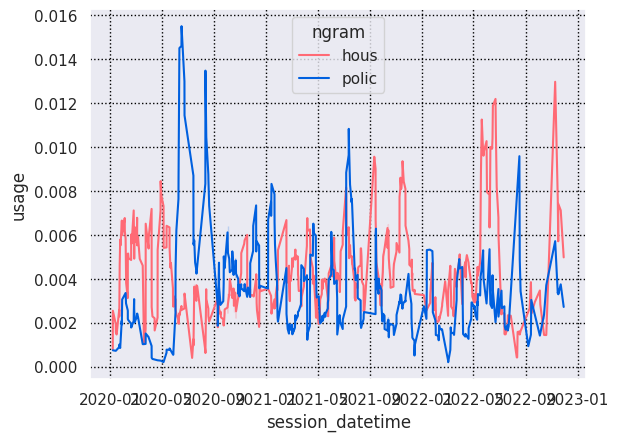

In [8]:
plot_ngrams(counts, ["police", "housing"])